<a href="https://colab.research.google.com/github/Ninja-State/NMA-DL-Project/blob/Miguel/NMA_DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Importing Libraries

import os, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#@title CUDA Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
#@title Plotting params

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
#@title Loading Spiking times
fname1 = ['steinmetz_st.npz']
fname1.append('steinmetz_wav.npz')
fname1.append('steinmetz_lfp.npz')
url2 = ["https://osf.io/4bjns/download"]
url2.append("https://osf.io/ugm9v/download")
url2.append("https://osf.io/kx3v9/download")


for j in range(len(url2)):
  if not os.path.isfile(fname1[j]):
    try:
      r = requests.get(url2[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname1[j], "wb") as fid:
          fid.write(r.content)


dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']
dat2 = dat_ST[11]
del dat_ST
print(dat2.keys())

dict_keys(['ss', 'ss_passive'])


In [5]:
#@title Load Binned Times

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)



alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [6]:
#@title DF form
dt_waveforms = 1/30000 # dt of waveform
binsize = dat['bin_size'] # bin times spikes
mean_firing = dat['spks'].mean(axis = (1,2)) * 1/binsize # computing mean firing rate
t_t_peak = dat['trough_to_peak'] * dt_waveforms * 1e3 # computing trough to peak time in ms


labeling_df = pd.DataFrame({
    "Mean Firing Rate": mean_firing,
    "Trough to peak": t_t_peak,
    "Region": dat['brain_area'],
    "Area":dat['brain_area']
})
labeling_df.replace(
    {
        "Area": {"CA1":"Hippocampus","DG":"Hippocampus","SUB":"Hippocampus",
        "VISp": "Visual Ctx", "VISam":"Visual Ctx","MD":"Thalamus","LGd":"Thalamus", "LH":"Thalamus",
        "PL":"Other Ctx","MOs":"Other Ctx","ACA":"Other Ctx"
        }
    }, inplace = True
)

# Labeling according to conditions, other is the default condition
labeling_df['Cell Type'] = "Other"
labeling_df.loc[(labeling_df['Mean Firing Rate']<5)&(labeling_df['Trough to peak']>0.4),'Cell Type'] = "Excitatory"
labeling_df.loc[(labeling_df['Mean Firing Rate']>5)&(labeling_df['Trough to peak']<0.4), 'Cell Type'] = "Inhibitory"

labeling_df.head(20)

,Mean Firing Rate,Trough to peak,Region,Area,Cell Type
0,0.731765,0.800000,VISp,Visual Ctx,Excitatory
1,0.237647,0.666667,VISp,Visual Ctx,Excitatory
2,5.368235,0.766667,VISp,Visual Ctx,Other
3,0.190588,0.566667,DG,Hippocampus,Excitatory
4,1.356471,0.633333,VISp,Visual Ctx,Excitatory
5,0.000000,0.733333,VISp,Visual Ctx,Excitatory
6,0.141176,0.600000,SUB,Hippocampus,Excitatory
7,2.327059,0.733333,DG,Hippocampus,Excitatory
8,0.030588,0.633333,VISp,Visual Ctx,Excitatory
9,0.798824,0.400000,VISp,Visual Ctx,Other


In [7]:
labeling_df['Region'].unique()

array(['VISp', 'DG', 'SUB', 'LGd', 'PL', 'root', 'MOs', 'ACA', 'CA1',
       'VISam', 'MD', 'LH'], dtype=object)

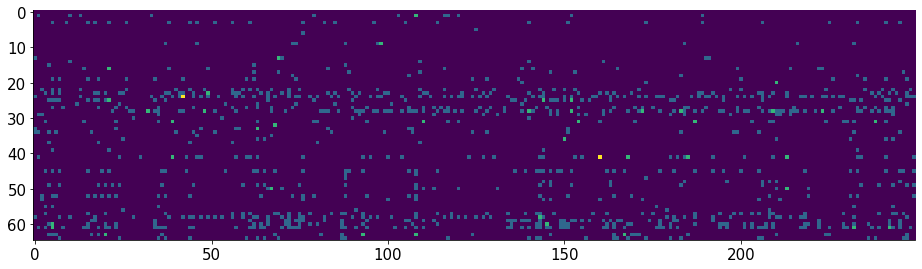

In [8]:
#dat['spks'][1,:,].shape
#Neurons,trials,time
plt.imshow(dat['spks'][dat['brain_area']=='DG',3,:])


In [9]:
#@title Raster visualizer
from ipywidgets import interact
import ipywidgets as widgets
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
is_correct = np.sign(dat['response'])==np.sign(vis_left-vis_right)
def raster_visualizer(area,trial):
  spikes= dat2['ss']
  plt.figure(figsize=(9,5))
  plt.eventplot(spikes[labeling_df['Area']==area][:,trial],color='k')
  #plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Excitatory')][:,trial]);
  #plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Other')][:,trial],color='k');
  #plt.eventplot(spikes[(labeling_df['Area']==area) & (labeling_df['Cell Type']=='Inhibitory')][:,trial],colors = 'r');
  #plt.yticks([]);
  plt.vlines(0.5,0,len(spikes[(labeling_df['Area']==area)])-10,'red','--',alpha=0.5)
  plt.ylabel('Neurons');
  plt.xlabel('Time ($s$)');
  plt.title(f'Trial was correct?:{is_correct[trial]}')
interact(raster_visualizer, area=['Hippocampus','Visual Ctx','Thalamus','Other Ctx'], trial=(0,339));

interactive(children=(Dropdown(description='area', options=('Hippocampus', 'Visual Ctx', 'Thalamus', 'Other Ct…

In [10]:
#@title Mean firing rate based on response
# response = dat['response'] # right - nogo - left (-1, 0, 1)

def mean_firing(area):
  Selection = (labeling_df['Area']==area) #& (labeling_df['Cell Type']=='Excitatory')
  spikes = dat['spks'][Selection].mean(axis = 0) #selecting spikes
  mean_fr_e = spikes[is_correct==True].mean(axis=(0))*1/binsize
  mean_fr_i = spikes[is_correct==False].mean(axis=(0))*1/binsize
  time = binsize * np.arange(dat['spks'].shape[-1])
  plt.plot(time, mean_fr_e,label='correct')
  plt.plot(time, mean_fr_i,label='incorrect')
  plt.axvline(x=0.5,ls = '--', alpha = 0.5, c = 'r', label='Stim')
  plt.axvline(x=np.mean(dat['response_time']),ls = '--', alpha = 0.5, c = 'k', label='Response')
  plt.ylabel('Mean Firing Rate ($Hz$)')
  plt.xlabel('Time ($ms$)')
  plt.legend()
interact(mean_firing, area=['Hippocampus','Visual Ctx','Thalamus','Other Ctx']);

interactive(children=(Dropdown(description='area', options=('Hippocampus', 'Visual Ctx', 'Thalamus', 'Other Ct…

In [11]:
class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi, nonlinearity = 'tanh')
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)

    return z, q

# Data to feed

Here we specify with which subset of data the RNN will be feed it.

In [12]:
Data_to_feed = dat['spks'][labeling_df['Area']=='Visual Ctx',:,:].T

Separating inputs and outputs:

In [30]:
# we separate the neuron data into two populations: the input and output
div_neurons = int(Data_to_feed.shape[-1]/2)
x = Data_to_feed

if Data_to_feed.shape[-1] % 2 == 0:
  x0 = torch.from_numpy(x[:, :, :div_neurons]).to(device).float()
  x1 = torch.from_numpy(x[:, :,div_neurons:]).to(device).float()
else:
  x0 = torch.from_numpy(x[:, :, :div_neurons+1]).to(device).float()
  x1 = torch.from_numpy(x[:, :,div_neurons:]).to(device).float()

print(f"Input shape: {x1.shape}")
print(f"Output shape. {x0.shape}")

Input shape: torch.Size([250, 340, 73])
Output shape. torch.Size([250, 340, 73])


In [32]:
NN1 = x1.shape[-1]
NN2 = x0.shape[-1]
ncomp = 10

In [35]:
def trainRNN(NN1,NN2,nlatents,niter=1000):
  net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
  net.fc.bias.data[:] = x1.mean((0,1))

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
  optimizer = torch.optim.Adam(net.parameters(), lr=.005)
  
  def Poisson_loss(lam, spk):
    return lam - spk * torch.log(lam)

  for k in range(niter):
  # the network outputs the single-neuron prediction and the latents
    z, y = net(x1)

  # our log-likelihood cost
    cost = Poisson_loss(z, x0).mean()

  # train the network as usual
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

    if k % 100 == 0:
      print(f'iteration {k}, cost {cost.item():.4f}')
  
  return z, y

In [38]:
z,y = trainRNN(NN1,NN2,ncomp)

iteration 0, cost 0.1442
iteration 100, cost 0.0559
iteration 200, cost 0.0531
iteration 300, cost 0.0525
iteration 400, cost 0.0519
iteration 500, cost 0.0521
iteration 600, cost 0.0515
iteration 700, cost 0.0514
iteration 800, cost 0.0512
iteration 900, cost 0.0511


In [66]:
rpred.shape

(250, 340, 73)

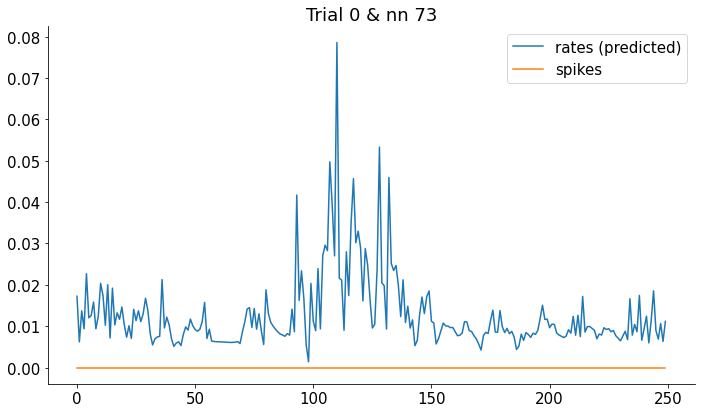

In [69]:
rpred = z.detach().cpu().numpy()

trial = 0
neuron = 73
plt.figure(figsize=(10, 6))
plt.plot(rpred[:,trial, 0])
plt.plot(x[:, trial, neuron]/100)

plt.legend(['rates (predicted)', 'spikes'])
plt.title(f'Trial {trial} & nn {neuron}')
plt.show()

In [64]:
x.shape

(250, 340, 145)

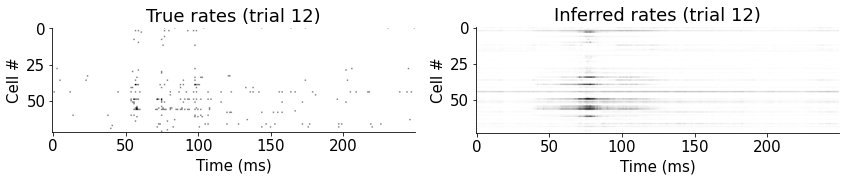

In [70]:
plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.imshow(x[:, 100, :div_neurons].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title('True rates (trial 12)')

plt.subplot(122)
plt.imshow(rpred[:, 100, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title('Inferred rates (trial 12)')
plt.show()

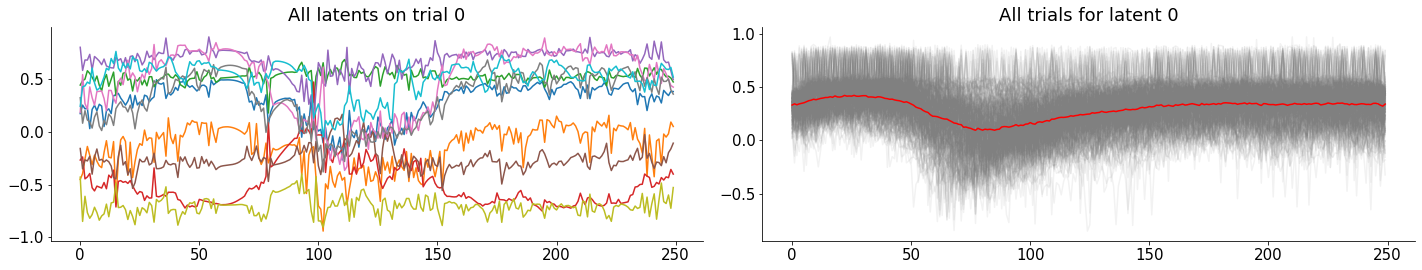

In [54]:
ycpu = y.detach().cpu().numpy()

plt.figure(figsize=(20, 4))
plt.subplot(121)
plt.plot(ycpu[:, 0, :]);
plt.title('All latents on trial 0')

plt.subplot(122)
plt.plot(ycpu[:, :, 0], alpha = 0.1, color ='gray');
plt.plot(ycpu[:, :, 0].mean(axis=1),color ='red')
plt.title('All trials for latent 0')
plt.show()